In [1]:
import numba
import pandas
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import LSTM

2022-12-26 16:23:02.966058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-26 16:23:04.829290: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda-11.7/lib64:
2022-12-26 16:23:04.832107: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda-11.7/lib64:
2022-12-26 16:23:04.832121: W tensorflow/compiler/tf2tensorrt/utils/py_utils.c

In [2]:
df = pandas.read_csv("1866_2022_3.csv")
date_time = pandas.to_datetime(df.pop('Date'), format='%d/%m/%Y %H:%M:%S')
print(df)

         Valeur  Source
0         3.050       3
1         3.300       3
2         3.550       3
3         3.800       3
4         4.070       3
...         ...     ...
1426559   1.931       3
1426560   1.915       3
1426561   1.918       3
1426562   1.942       3
1426563   1.998       3

[1426564 rows x 2 columns]


In [3]:
df['Time'] = [10*i for i in range(len(df))]

In [4]:
values = df.values[:,0]
time = df.values[:,2]
print(f"Values : {values}, shape : {values.shape}")
print(f"Time : {time}")

Values : [3.05  3.3   3.55  ... 1.918 1.942 1.998], shape : (1426564,)
Time : [0.000000e+00 1.000000e+01 2.000000e+01 ... 1.426561e+07 1.426562e+07
 1.426563e+07]


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(time, values, test_size = 0.2)

In [6]:
train_ds = tf.keras.utils.timeseries_dataset_from_array(
          data=X_train,
          targets=None,
          sequence_length=1,
          sequence_stride=1,
          sampling_rate = 0.5,
          batch_size=32,)

2022-12-26 16:23:19.305390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-26 16:23:19.424952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-26 16:23:19.425458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-26 16:23:19.429962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [7]:
X_train = X_train.reshape([len(X_train),1,1])
X_test = X_test.reshape([len(X_test),1,1])
Y_train = Y_train.reshape([len(Y_train),1,1])
Y_test = Y_test.reshape([len(Y_test),1,1])

In [8]:
X_train.shape

(1141251, 1, 1)

In [9]:
X_train[:5], Y_train[:5]

(array([[[ 4030980.]],
 
        [[11417860.]],
 
        [[ 9610540.]],
 
        [[ 7038490.]],
 
        [[ 7633200.]]]),
 array([[[5.37 ]],
 
        [[5.64 ]],
 
        [[5.126]],
 
        [[6.868]],
 
        [[1.435]]]))

In [52]:
y_train = to_categorical(Y_train)

In [60]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(64, activation='relu'),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(1),
    # Shape => [batch, out_steps, features].
    #tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
MAX_EPOCHS = 50
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=2,
                                                mode='min')

multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError(), "accuracy"])

history = multi_lstm_model.fit(X_train, Y_train, epochs=MAX_EPOCHS,
                  callbacks=[early_stopping])

Epoch 1/50


In [65]:
model = Sequential()
model.add(Dense(1))
model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model.add(Dense(1))

In [66]:
model.compile(optimizer='adam', loss='mse')

In [67]:
model.fit(X_train,Y_train)

ValueError: in user code:

    File "/home/alex/miniconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/alex/miniconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/alex/miniconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/alex/miniconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/alex/miniconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/alex/miniconda3/lib/python3.10/site-packages/keras/engine/input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_13' (type Sequential).
    
    Input 0 of layer "dense_12" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential_13' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=int64)
      • training=True
      • mask=None


In [74]:
CONV_WIDTH = 2
modelCNN = Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH), padding = 'same'),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(1,kernel_initializer=tf.initializers.zeros())
])

In [75]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=2,
                                                mode='min')
modelCNN.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(learning_rate = 0.1),
            metrics=[tf.metrics.MeanAbsoluteError()])

In [76]:
history = modelCNN.fit(X_train,Y_train, epochs = 50, callbacks=[early_stopping])

Epoch 1/50
35665/35665 [==============================] - 218s 6ms/step - loss: 109770.6797 - mean_absolute_error: 16.2439
Epoch 2/50
35665/35665 [==============================] - 217s 6ms/step - loss: 2.5716 - mean_absolute_error: 1.3753
Epoch 3/50
35665/35665 [==============================] - 249s 7ms/step - loss: 2.5715 - mean_absolute_error: 1.3753
Epoch 4/50
35665/35665 [==============================] - 254s 7ms/step - loss: 334.2483 - mean_absolute_error: 1.4611
Epoch 5/50
35665/35665 [==============================] - 257s 7ms/step - loss: 2.5716 - mean_absolute_error: 1.3753


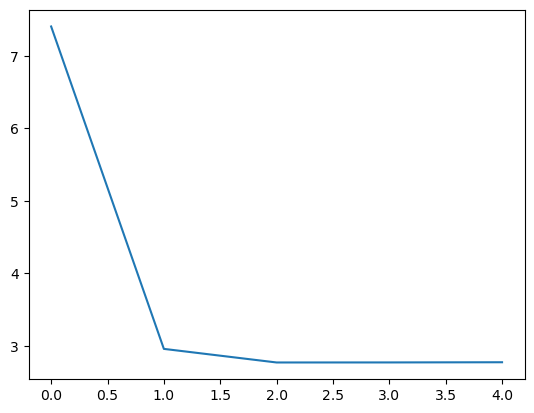

In [60]:
plt.plot(history.history["loss"][2:])

In [63]:
modelCNN.predict([[[80010+10*i]] for i in range(64)])

2/2 [==============================] - 0s 4ms/step


array([[[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.2348323]],

       [[4.

6.06